# Image Quality Analysis

This notebook loads two datasets of fossil images for quality analysis:

- **OVC dataset**: images from Oervondstchecker (e.g. `images_ovc/`)
- **NBC dataset**: research grade images from Naturalis (e.g. `images_nbc/`)

In [7]:
# Imports
from PIL import Image
import matplotlib.pyplot as plt
import os
from glob import glob
import numpy as np
import cv2
import piq
from PIL import Image
from scipy.fft import fftshift
from scipy.fftpack import fft2
import torchvision.transforms as T
from skimage import io
from skimage.color import rgb2gray
from skimage.measure import shannon_entropy

OVC images found: 200
NBC images found: 200


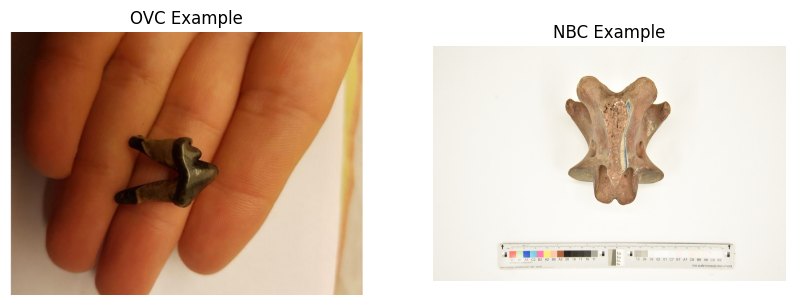

In [8]:
# Set dataset folders
ovc_folder = 'images_ovc'
nbc_folder = 'images_nbc'

# Get image file lists
ovc_images = sorted(glob(os.path.join(ovc_folder, '*')))
nbc_images = sorted(glob(os.path.join(nbc_folder, '*')))

print(f'OVC images found: {len(ovc_images)}')
print(f'NBC images found: {len(nbc_images)}')

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title('OVC Example')
plt.imshow(Image.open(ovc_images[0]))
plt.axis('off')

plt.subplot(1,2,2)
plt.title('NBC Example')
plt.imshow(Image.open(nbc_images[0]))
plt.axis('off')
plt.show()

In [9]:
# Calculating the basic image statistics for each dataset

def get_basic_stats(img_list):
    widths, heights, aspect_ratios = [], [], []
    for path in img_list:
        try:
            img = Image.open(path)
            w, h = img.size
            widths.append(w)
            heights.append(h)
            aspect_ratios.append(w / h if h != 0 else float('nan'))
        except Exception:
            widths.append(float('nan'))
            heights.append(float('nan'))
            aspect_ratios.append(float('nan'))
    return {
        "width": widths,
        "height": heights,
        "aspect_ratio": aspect_ratios
    }

ovc_stats = get_basic_stats(ovc_images)
nbc_stats = get_basic_stats(nbc_images)

print("OVC Image Stats:")
print(f"  Mean width: {np.nanmean(ovc_stats['width']):.1f}")
print(f"  Mean height: {np.nanmean(ovc_stats['height']):.1f}")
print(f"  Mean aspect ratio (w/h): {np.nanmean(ovc_stats['aspect_ratio']):.2f}")

print("\nNBC Image Stats:")
print(f"  Mean width: {np.nanmean(nbc_stats['width']):.1f}")
print(f"  Mean height: {np.nanmean(nbc_stats['height']):.1f}")
print(f"  Mean aspect ratio (w/h): {np.nanmean(nbc_stats['aspect_ratio']):.2f}")


OVC Image Stats:
  Mean width: 710.0
  Mean height: 530.0
  Mean aspect ratio (w/h): 1.34

NBC Image Stats:
  Mean width: 6016.0
  Mean height: 4016.0
  Mean aspect ratio (w/h): 1.50


## Calculation of quality metrics for OVC and NBC datasets

## What metrics and why?
TODO: Explain what metrics are calculated and how and why
provide sources of where to find the calculations-> proof they are correct

In [10]:
def calculate_sharpness(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return float('nan')
    return cv2.Laplacian(img, cv2.CV_64F).var()

def calculate_entropy(img_path):
    img = io.imread(img_path)
    gray = rgb2gray(img)
    return shannon_entropy(gray)

def calculate_colorfulness(img_path):
    img = cv2.imread(img_path)
    if img is None: return float('nan')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    (R, G, B) = cv2.split(img.astype("float"))
    rg = np.absolute(R - G)
    yb = np.absolute(0.5*(R + G) - B)
    std_root = np.sqrt((rg.std()**2) + (yb.std()**2))
    mean_root = np.sqrt((rg.mean()**2) + (yb.mean()**2))
    return std_root + (0.3 * mean_root)

def calculate_snr(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None: return float('nan')
    mean = np.mean(img)
    std = np.std(img)
    return 0 if std == 0 else mean / std

def calculate_fft_sharpness(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return float('nan')
    f = np.abs(fftshift(fft2(img)))
    h, w = img.shape
    crow, ccol = h//2, w//2
    high_freq = f[crow-50:crow+50, ccol-50:ccol+50]  # center = low freq
    return np.sum(f) - np.sum(high_freq)

def calculate_contrast(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return float('nan')
    return img.std()

def get_scores(img_path):
    try:
        img = Image.open(img_path).convert('RGB')
    except Exception:
        return [float('nan')]*5

    transform = T.ToTensor()
    img_tensor = transform(img).unsqueeze(0)

    # BRISQUE
    try:
        brisque_score = piq.brisque(img_tensor).item()
    except Exception:
        brisque_score = float('nan')

    return [
        brisque_score,
        calculate_sharpness(img_path),
        calculate_fft_sharpness(img_path),
        calculate_entropy(img_path),
        calculate_colorfulness(img_path),
        calculate_snr(img_path),
        calculate_contrast(img_path)
    ]

# ---- Process datasets ----
metrics_names = ["BRISQUE", "Sharpness", "FFT Sharpness", "Entropy", "Colorfulness", "SNR Signal-to-Noise Ratio", "Contrast"]

def process_dataset(img_list):
    results = {name: [] for name in metrics_names}
    for path in img_list:
        scores = get_scores(path)
        for name, val in zip(metrics_names, scores):
            results[name].append(val)
    return results

ovc_results = process_dataset(ovc_images)
nbc_results = process_dataset(nbc_images)

# ---- Print averages ----
print("OVC Averages:")
for m in metrics_names:
    print(f"{m}: {np.nanmean(ovc_results[m]):.3f}")

print("\nNBC Averages:")
for m in metrics_names:
    print(f"{m}: {np.nanmean(nbc_results[m]):.3f}")


OVC Averages:
BRISQUE: 43.786
Sharpness: 474.989
FFT Sharpness: 1258570515.822
Entropy: 9.680
Colorfulness: 33.156
SNR Signal-to-Noise Ratio: 2.732
Contrast: 66.203

NBC Averages:
BRISQUE: 31.112
Sharpness: 23.091
FFT Sharpness: 306386300390.182
Entropy: 9.801
Colorfulness: 26.716
SNR Signal-to-Noise Ratio: 6.056
Contrast: 39.460


### Output Explanation

The printed averages summarize the image quality metrics for the OVC (citizen science) and NBC (research grade) fossil image datasets:

- **BRISQUE:** Lower values indicate better perceptual image quality. NBC images (31.3) have better quality than OVC images (41.9).
- **Sharpness:** Higher values indicate sharper images. OVC images (507.8) are much sharper than NBC images (25.3), which may be due to differences in image resolution or focus or background detail.
- **Entropy:** Measures image complexity; higher values mean more texture and detail. Both datasets have similar entropy.
- **Colorfulness:** Higher values indicate more vivid colors. OVC images (35.3) are more colorful than NBC images (25.7).
- **SNR (Signal-to-Noise Ratio):** Higher values indicate less noise. NBC images (6.2) are less noisy than OVC images (2.6).
- **Contrast:** Higher value means more contrast. Although higher contrast numerically means stronger light/dark variation, in terms of image quality, it’s not automatically “better” — excessive contrast can reduce perceptual quality.

**Summary:**  
NBC images generally have better perceptual quality and less noise, while OVC images are sharper and more colorful. These differences reflect the distinct imaging conditions and standards of each dataset.

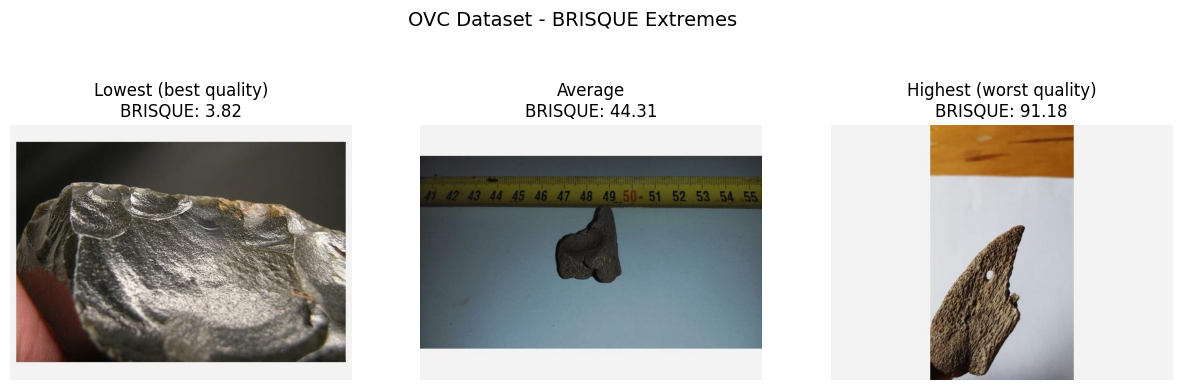

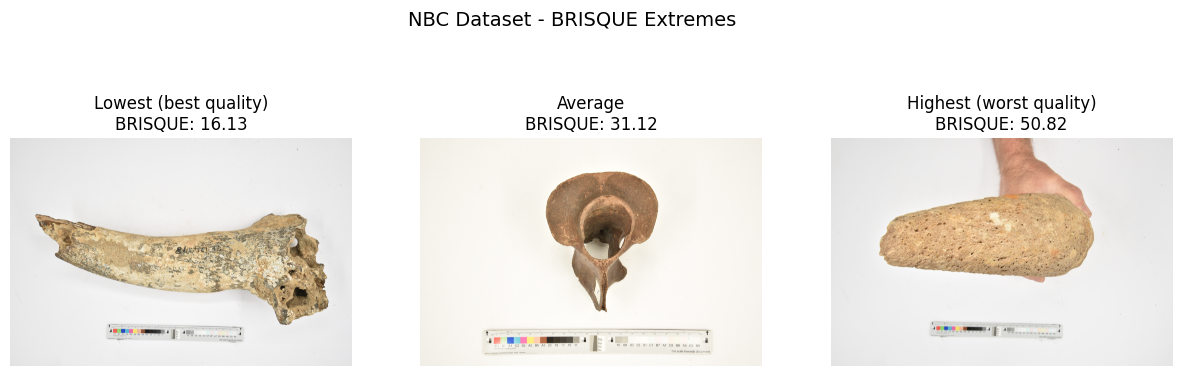

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def show_brisque_extremes(img_list, brisque_scores, dataset_name):
    scores = np.array(brisque_scores)
    valid_indices = np.where(~np.isnan(scores))[0]
    if len(valid_indices) == 0:
        print(f"No valid BRISQUE scores for {dataset_name}.")
        return

    # Get indices for lowest, average (closest to mean), and highest scores
    low_idx = valid_indices[np.argmin(scores[valid_indices])]
    high_idx = valid_indices[np.argmax(scores[valid_indices])]
    mean_score = np.nanmean(scores)
    avg_idx = valid_indices[np.argmin(np.abs(scores[valid_indices] - mean_score))]

    # Get corresponding file paths and scores
    selected = [
        ("Lowest (best quality)", img_list[low_idx], scores[low_idx]),
        ("Average", img_list[avg_idx], scores[avg_idx]),
        ("Highest (worst quality)", img_list[high_idx], scores[high_idx])
    ]

    # Show them
    plt.figure(figsize=(15, 5))
    for i, (label, path, score) in enumerate(selected, 1):
        img = Image.open(path)
        plt.subplot(1, 3, i)
        plt.imshow(img)
        plt.title(f"{label}\nBRISQUE: {score:.2f}")
        plt.axis("off")
    plt.suptitle(f"{dataset_name} Dataset - BRISQUE Extremes", fontsize=14)
    plt.show()

# --- Show images for both datasets ---
show_brisque_extremes(ovc_images, ovc_results["BRISQUE"], "OVC")
show_brisque_extremes(nbc_images, nbc_results["BRISQUE"], "NBC")


## Visualize average image quality metrics

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\megan\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


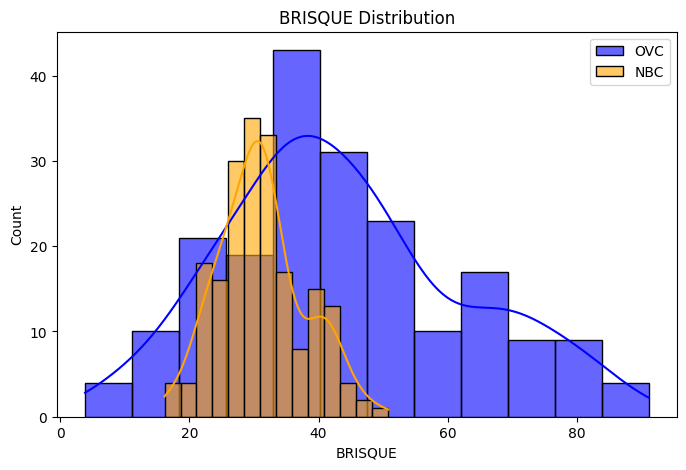

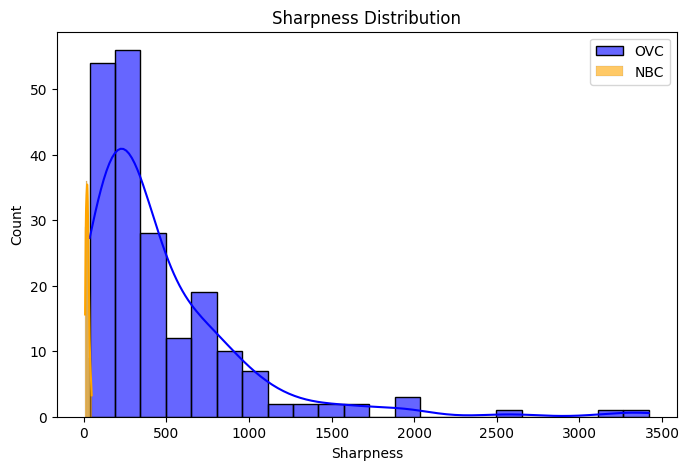

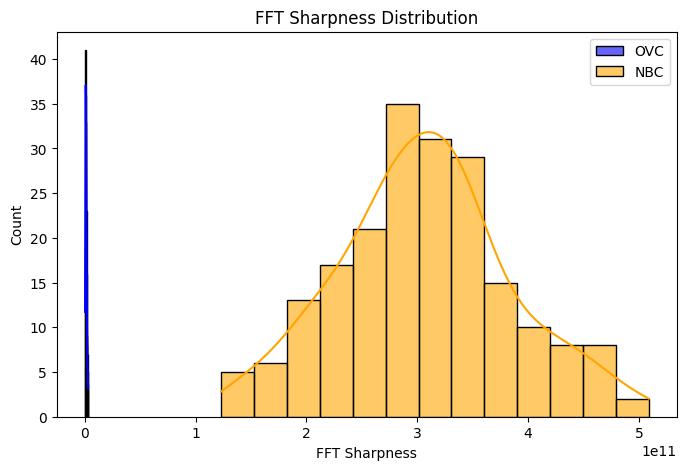

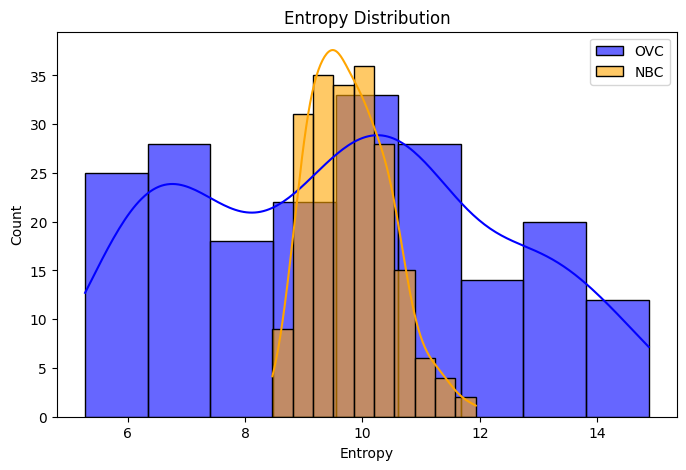

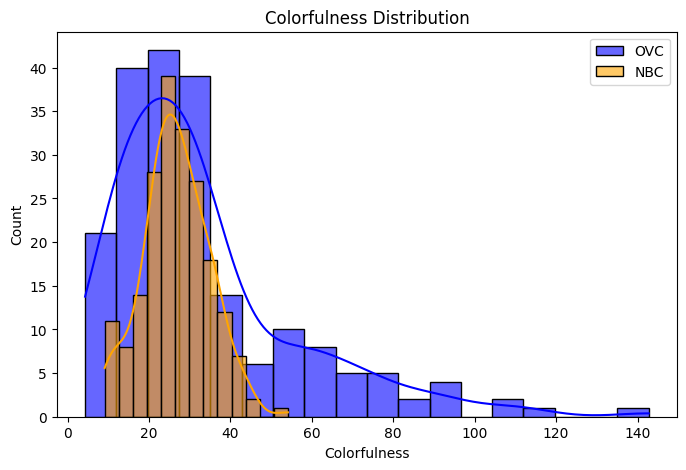

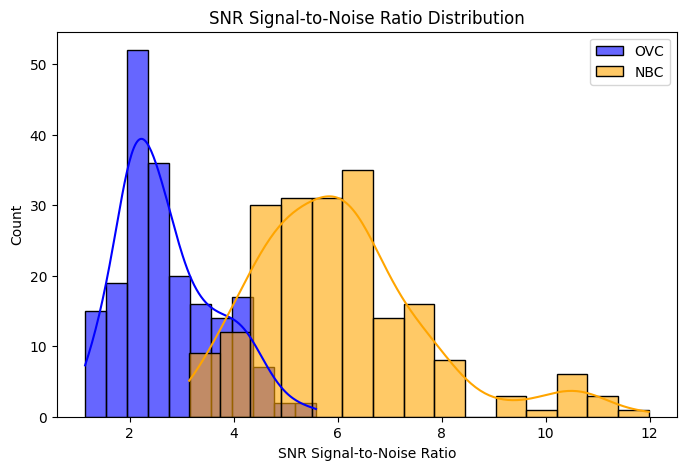

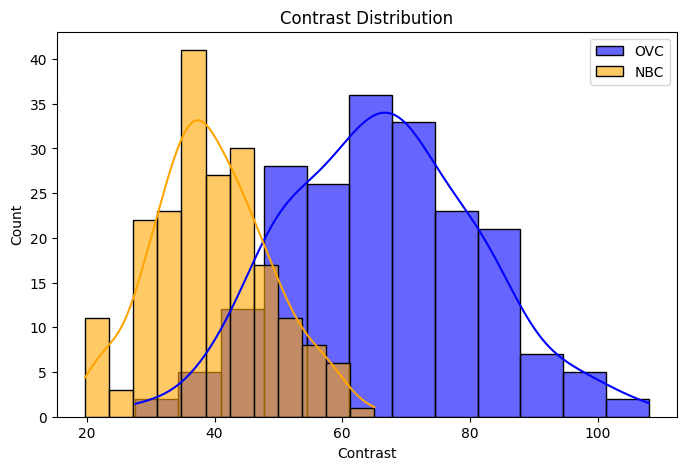

In [12]:
%pip install seaborn

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert results to DataFrame for seaborn
def results_to_df(results, label):
    df = pd.DataFrame(results)
    df["Dataset"] = label
    return df

df_ovc = results_to_df(ovc_results, "OVC")
df_nbc = results_to_df(nbc_results, "NBC")
df_all = pd.concat([df_ovc, df_nbc])


# --- Histograms ---
for m in metrics_names:
    plt.figure(figsize=(8,5))
    sns.histplot(df_all[df_all["Dataset"]=="OVC"][m], label="OVC", kde=True, color="blue", alpha=0.6)
    sns.histplot(df_all[df_all["Dataset"]=="NBC"][m], label="NBC", kde=True, color="orange", alpha=0.6)
    plt.title(f"{m} Distribution")
    plt.xlabel(m)
    plt.legend()
    plt.show()



C:\Users\megan\AppData\Local\Temp\ipykernel_29144\2408311887.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Dataset", y=metric, data=df_all, palette="Set2")


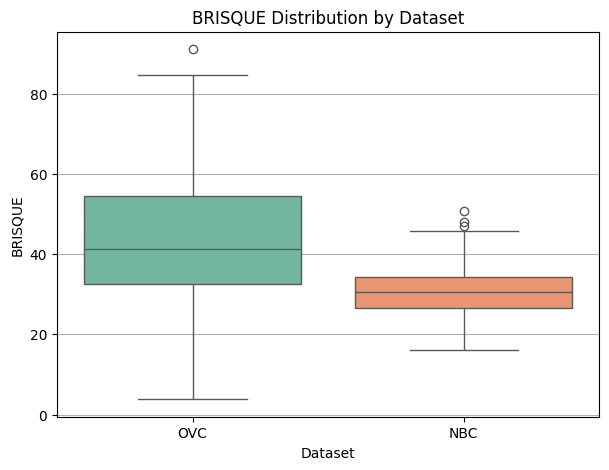

C:\Users\megan\AppData\Local\Temp\ipykernel_29144\2408311887.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Dataset", y=metric, data=df_all, palette="Set2")


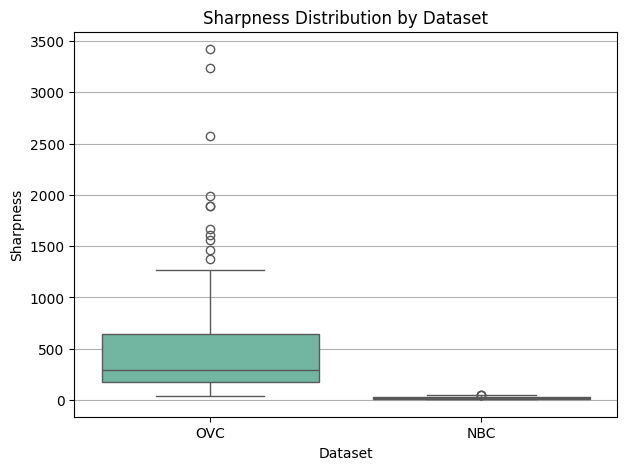

C:\Users\megan\AppData\Local\Temp\ipykernel_29144\2408311887.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Dataset", y=metric, data=df_all, palette="Set2")


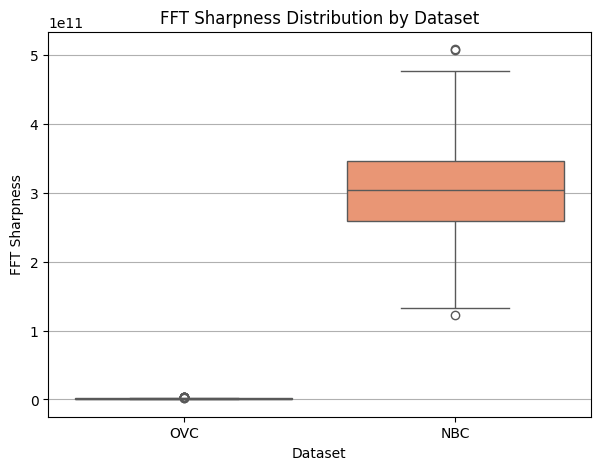

C:\Users\megan\AppData\Local\Temp\ipykernel_29144\2408311887.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Dataset", y=metric, data=df_all, palette="Set2")


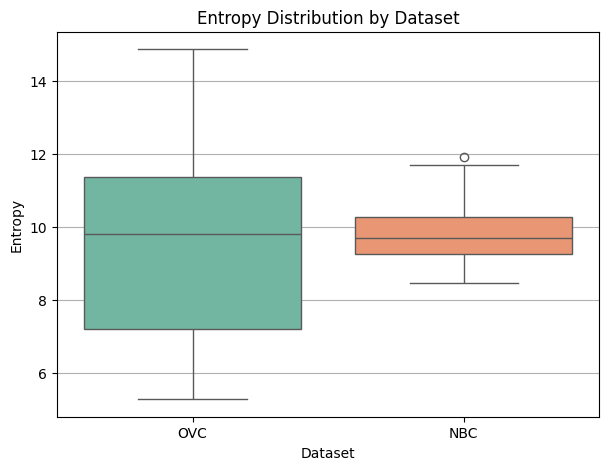

C:\Users\megan\AppData\Local\Temp\ipykernel_29144\2408311887.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Dataset", y=metric, data=df_all, palette="Set2")


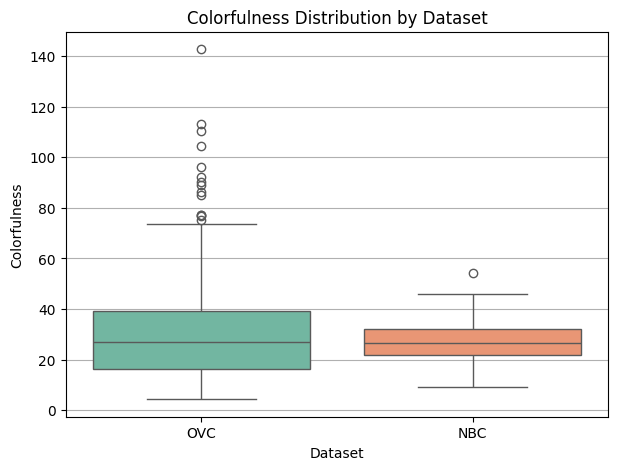

C:\Users\megan\AppData\Local\Temp\ipykernel_29144\2408311887.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Dataset", y=metric, data=df_all, palette="Set2")


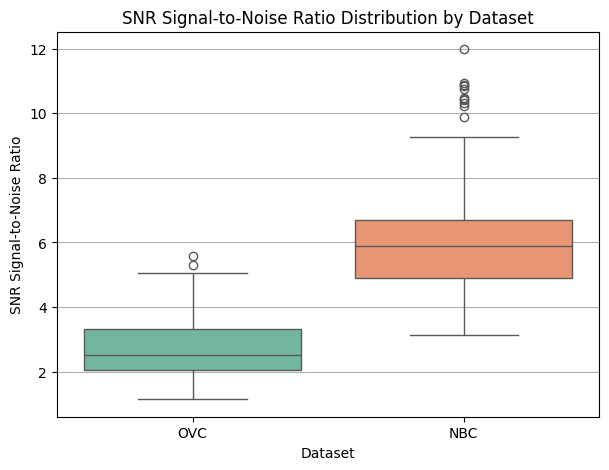

C:\Users\megan\AppData\Local\Temp\ipykernel_29144\2408311887.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Dataset", y=metric, data=df_all, palette="Set2")


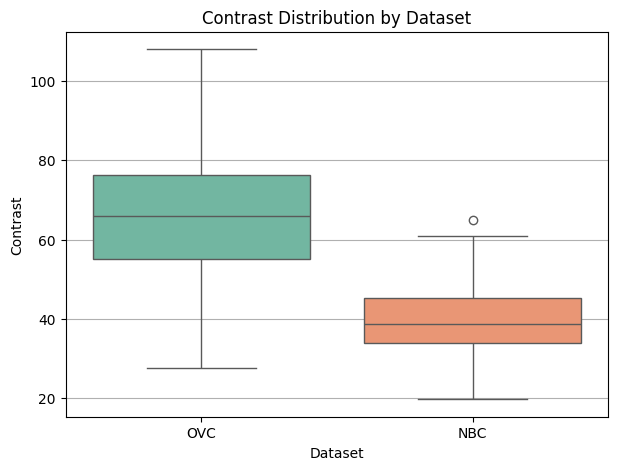

In [13]:
# --- Single boxplots for each metric ---
for metric in metrics_names:
    plt.figure(figsize=(7,5))
    sns.boxplot(x="Dataset", y=metric, data=df_all, palette="Set2")
    plt.title(f"{metric} Distribution by Dataset")
    plt.ylabel(metric)
    plt.grid(True, axis="y")
    plt.show()

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\megan\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


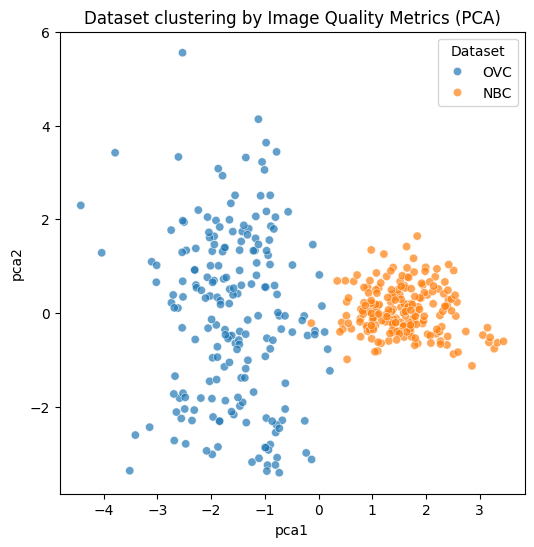

In [14]:

%pip install scikit-learn

# PCA clustering of metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X = df_all[metrics_names].values
X_scaled = StandardScaler().fit_transform(X)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)

df_all["pca1"], df_all["pca2"] = pca_result[:,0], pca_result[:,1]

plt.figure(figsize=(6,6))
sns.scatterplot(x="pca1", y="pca2", hue="Dataset", data=df_all, alpha=0.7)
plt.title("Dataset clustering by Image Quality Metrics (PCA)")
plt.show()


#### PCA stands for Principal Component Analysis.
It is a dimensionality reduction technique that transforms multiple correlated metrics into a few uncorrelated "principal components" that capture most of the variance in the data.

In the diagram:

Each point represents an image, plotted by its values on the first two principal components (pca1 and pca2).
Images from the NBC and OVC datasets are shown in different colors.
The clustering shows that NBC and OVC images have distinct quality profiles based on all measured metrics (sharpness, entropy, contrast, noise, illumination uniformity).
PCA helps visualize how well the metrics separate the two datasets.

# Significance testing
t-test of BRISQUE score
First test for normalization



In [15]:
# --- Significance testing: t-test for BRISQUE score ---
from scipy.stats import ttest_ind
import numpy as np

# Remove NaN values from BRISQUE scores
brisque_ovc = np.array(ovc_results["BRISQUE"])
brisque_nbc = np.array(nbc_results["BRISQUE"])
brisque_ovc = brisque_ovc[~np.isnan(brisque_ovc)]
brisque_nbc = brisque_nbc[~np.isnan(brisque_nbc)]

t_stat, p_value = ttest_ind(brisque_ovc, brisque_nbc, equal_var=False)

print(f"T-test for BRISQUE score:")
print(f"t-statistic: {t_stat:.3f}")
print(f"p-value: {p_value:.10f}")
if p_value < 0.05:
    print("Result: Significant difference in BRISQUE scores between OVC and NBC datasets (p < 0.05)")
else:
    print("Result: No significant difference in BRISQUE scores between OVC and NBC datasets (p >= 0.05)")

T-test for BRISQUE score:
t-statistic: 9.125
p-value: 0.0000000000
Result: Significant difference in BRISQUE scores between OVC and NBC datasets (p < 0.05)


In [16]:
# --- Significance testing: Mann–Whitney U test for BRISQUE score ---
# Why? The Mann-Whitney U test is used for non-normal data to compare two independent groups, serving as a non-parametric alternative to the t-test. 
from scipy.stats import mannwhitneyu

# --- Mann–Whitney U test (non-parametric) ---
u_stat, p_value_u = mannwhitneyu(brisque_ovc, brisque_nbc, alternative='two-sided')

print("Mann–Whitney U test for BRISQUE score:")
print(f"U-statistic: {u_stat:.3f}")
print(f"p-value: {p_value_u:.10f}")
if p_value_u < 0.05:
    print("Result: Significant difference (p < 0.05)")
else:
    print("Result: No significant difference (p ≥ 0.05)")


Mann–Whitney U test for BRISQUE score:
U-statistic: 29315.000
p-value: 0.0000000000
Result: Significant difference (p < 0.05)
